# Week 3 - Clustering & Topic Modeling

This week, we take a text corpus that we have developed, and we first break it into discrete document chunks through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of content clustering called topic modeling. This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. Finally, we will consider how to construct models that take document cluster and topic loading as predictive features.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

You have to download all the nltk documents
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to ../data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to ../data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to ../data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to ../data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to ../data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to ../data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to ../data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to ../data...
[nltk_data]    |   Unzipping corpora/chat80.zip.
[nltk_data]    | 

[nltk_data]    | Downloading package webtext to ../data...
[nltk_data]    |   Unzipping corpora/webtext.zip.
[nltk_data]    | Downloading package wordnet to ../data...
[nltk_data]    |   Unzipping corpora/wordnet.zip.
[nltk_data]    | Downloading package wordnet_ic to ../data...
[nltk_data]    |   Unzipping corpora/wordnet_ic.zip.
[nltk_data]    | Downloading package words to ../data...
[nltk_data]    |   Unzipping corpora/words.zip.
[nltk_data]    | Downloading package ycoe to ../data...
[nltk_data]    |   Unzipping corpora/ycoe.zip.
[nltk_data]    | Downloading package rslp to ../data...
[nltk_data]    |   Unzipping stemmers/rslp.zip.
[nltk_data]    | Downloading package maxent_treebank_pos_tagger to
[nltk_data]    |     ../data...
[nltk_data]    |   Unzipping taggers/maxent_treebank_pos_tagger.zip.
[nltk_data]    | Downloading package universal_tagset to ../data...
[nltk_data]    |   Unzipping taggers/universal_tagset.zip.
[nltk_data]    | Downloading package maxent_ne_chunker to ..

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [100]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'description', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [101]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [102]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,category,source_file,text
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ..."
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom"
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not..."
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [103]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [104]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [105]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [106]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [107]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [108]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.046688020755456),
 ('certain', 0.1589865268627092),
 ('apple', 0.22685454684169398),
 ('13', 0.1411362504801527),
 ('rgb', 0.1817286448065436),
 ('monitors', 0.1619412292430009),
 ('there', 0.0749569030656185),
 ('has', 0.07484299310086841),
 ('been', 0.095991006908172),
 ('problem', 0.18819404816424326),
 ('with', 0.05464092321093494),
 ('the', 0.1109950967372947),
 ('high', 0.12601141569529475),
 ('voltage', 0.19706119834212132),
 ('capasitor', 0.242206441914102),
 ('knows', 0.16299450361806797),
 ('about', 0.15540750198460515),
 ('this', 0.05749878121929968),
 ('and', 0.04330392033255178),
 ('is', 0.04793741654764163)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [109]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [110]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
5       What is the value of an SE (HDFD) 4/20?\n\n-David
6       \n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7       \n\n\n    Nope. The Apple 16" monitor does not...
8       \n\nIs it a hidden option?  I'm using PowerStr...
9       \n\n\nThe previous article referred to the fac...
10      \n\n\n    Yes. That is exactly what it means. ...
11      I saw once an article about a new line of Macs...
12      So, will it be possible to have a NuBus or PDS...
13      \n\n\nWho knows... I just quoted what was "wri...
14      \n\nI also returned PB memory last summer for ...
15      \n\nI think all Powerbooks use the same 2 Meg ...
16      A question in general about displaying NTSC th...
17      The li

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [111]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [112]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [113]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [114]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [115]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'base', 'brier_score_loss', 'calinski_harabaz_score', 'classification', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'mean_absolute_error', 'mean_squared_error', 'mean_squared_log_error', 'median_absolute_error', 'mutual_info_score', 'normalized_mutual_info_score', 'pairwise', 'pairwise_distances', 'pairwise_distances_argmin', 'pairwise_distances_argmin_min', 'pairwise_fast', 'pairwise_kernels', 'precision_recall_cur

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [116]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,category,source_file,text,kmeans_predictions
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ...",0
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...,0
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...,0
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom",0
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...,0
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David,0
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,0
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not...",0
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...,0
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...,0


We can also look at the distinguishing features in each cluster:

In [117]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 know
 thanks
 mac
 does
 just
 use
 drive
 like
 apple
 don


Cluster 1:
 car
 cars
 engine
 like
 just
 good
 think
 don
 dealer
 oil


Cluster 2:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 sell
 interested
 price


Cluster 3:
 window
 server
 motif
 widget
 program
 application
 use
 using
 like
 windows




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [118]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [119]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [120]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

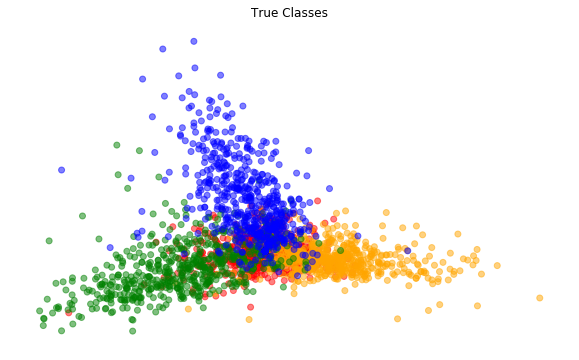

In [121]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

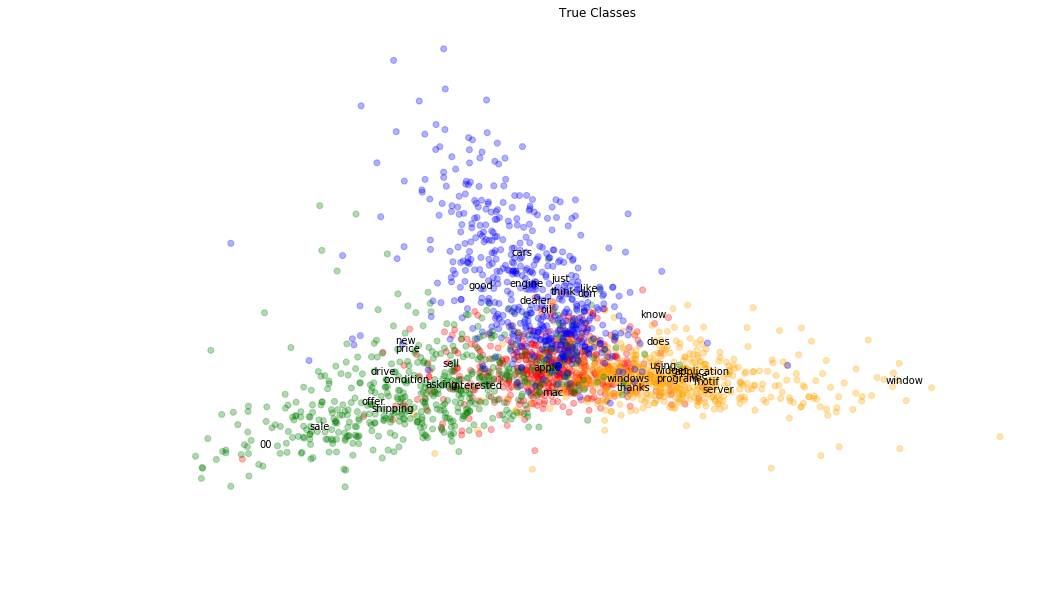

In [122]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [123]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

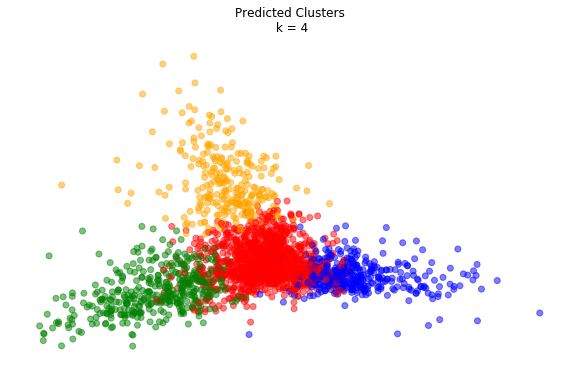

In [124]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [125]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [126]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters

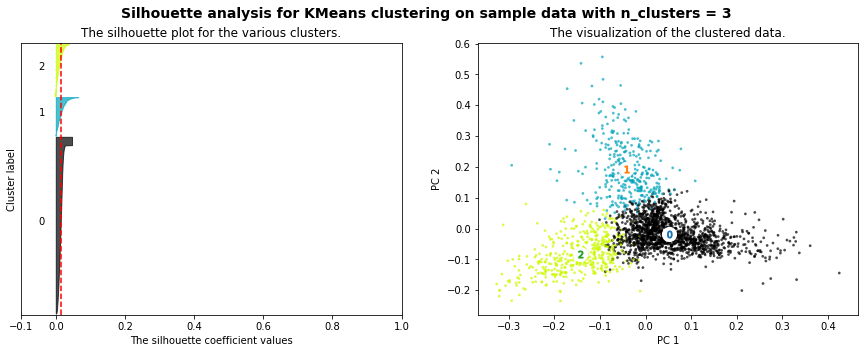

For n_clusters = 3, The average silhouette_score is : 0.014


In [127]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

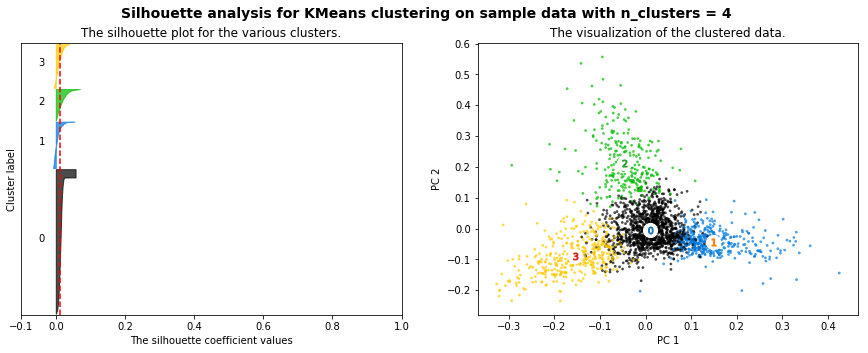

For n_clusters = 4, The average silhouette_score is : 0.012


In [128]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

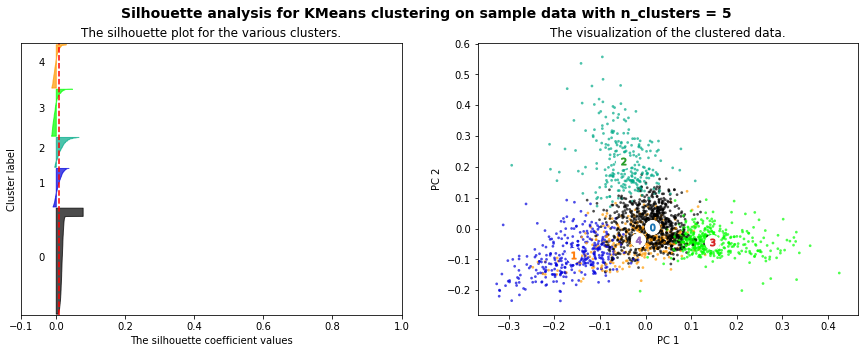

For n_clusters = 5, The average silhouette_score is : 0.010


In [129]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

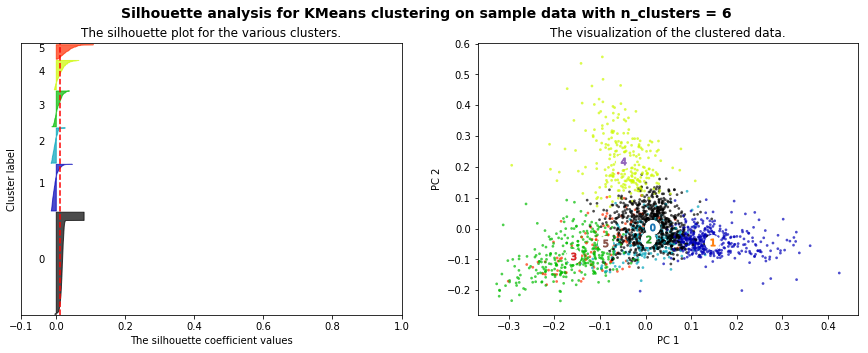

For n_clusters = 6, The average silhouette_score is : 0.011


In [130]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [131]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [132]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [133]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [134]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [135]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [136]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

And visualize:

In [137]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

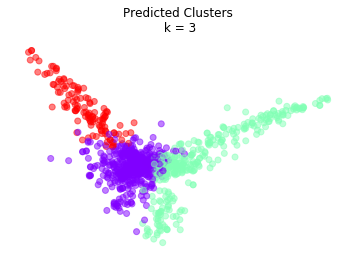

In [138]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters; with Silhouette analysis or maybe some of the metric although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [139]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
5,5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy13.txt,raw/Kennedy/01Aug2006Kennedy13.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
6,6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy14.txt,raw/Kennedy/01Aug2006Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
7,7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy5.txt,raw/Kennedy/01Aug2007Kennedy5.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,0
8,8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy6.txt,raw/Kennedy/01Aug2007Kennedy6.txt,FOR IMMEDIATE RELEASE Rachel Racus...,Kennedy,2
9,9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy7.txt,raw/Kennedy/01Aug2007Kennedy7.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,2


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

Importing Brown Corpora

In [15]:
from nltk.corpus import brown
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to /Users/arielazar/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [16]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [215]:
#categories = [
# 'news',
# 'belles_lettres',
# 'editorial',
# 'fiction',
# 'government']
#BrownCatDF = pandas.DataFrame(columns = ['text','category','fileid'])
#
#for category in brown.categories():
#    for fileid in brown.fileids():
#        document = ' '.join(brown.words(fileid))
#        BrownCatDF = BrownCatDF.append(pandas.DataFrame({'text' : [document], 'category' : '', 'fileid' : [fileid]}))

#BrownCatDF[1000:1100]

,category,fileid,text
0,,ca01,The Fulton County Grand Jury said Friday an in...
0,,ca02,"Austin , Texas -- Committee approval of Gov. P..."
0,,ca03,Several defendants in the Summerdale police bu...
0,,ca04,Oslo The most positive element to emerge from ...
0,,ca05,East Providence should organize its civil defe...
0,,ca06,Plainfield -- James P. Mitchell and Sen. Walte...
0,,ca07,Resentment welled up yesterday among Democrati...
0,,ca08,"Appointment of William S. Pfaff Jr. , 41 , as ..."
0,,ca09,City Controller Alexander Hemphill charged Tue...
0,,ca10,Vincent G. Ierulli has been appointed temporar...


Opening dataframe saved as csv. Data has 1000 documents classified in 15 different genres.

In [216]:
BrownCatDF =  pandas.read_csv('BrownCatDF.csv', sep=',')
BrownCatDF

,category,text
0,news,The Fulton County Grand Jury said Friday an in...
1,news,"Austin , Texas -- Committee approval of Gov. P..."
2,news,Several defendants in the Summerdale police bu...
3,news,Oslo The most positive element to emerge from ...
4,news,East Providence should organize its civil defe...
5,news,Plainfield -- James P. Mitchell and Sen. Walte...
6,news,Resentment welled up yesterday among Democrati...
7,news,"Appointment of William S. Pfaff Jr. , 41 , as ..."
8,news,City Controller Alexander Hemphill charged Tue...
9,news,Vincent G. Ierulli has been appointed temporar...


I am now converting the data into word count vectors in order to use this information as an input for the clusters analysis

In [217]:
#First it needs to be initialized
BrownCatCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
BrownCatVects = BrownCatCountVectorizer.fit_transform(BrownCatDF['text'])
print(BrownCatVects.shape)

(1000, 42396)


I now start the term frequency–inverse document frequency(tf-idf), a method for weighting document-distinguishing words.

In [218]:
#initialize
BrownCatTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(BrownCatVects)
#train
BrownCatTF = BrownCatTFTransformer.transform(BrownCatVects)
print(BrownCatTF.shape)

(1000, 42396)


This gives us the tf-idf for each word in each text

In [266]:
list(zip(BrownCatCountVectorizer.vocabulary_.keys(), BrownCatTF.data))[:20]

[('the', 0.5010397358525092),
 ('fulton', 0.269849737926772),
 ('county', 0.1493635515483272),
 ('grand', 0.04481691854228752),
 ('jury', 0.238681304964719),
 ('said', 0.11288947212604236),
 ('friday', 0.04751341421717589),
 ('an', 0.019472744657081757),
 ('investigation', 0.01160882130063088),
 ('of', 0.21011343761556836),
 ('atlanta', 0.10800743537315541),
 ('recent', 0.007835478701868112),
 ('primary', 0.039830280412887255),
 ('election', 0.17187386778908278),
 ('produced', 0.00975703980722317),
 ('no', 0.013701833405506405),
 ('evidence', 0.007808763554563976),
 ('that', 0.09051040389593713),
 ('any', 0.0036970778296278447),
 ('irregularities', 0.05182178432927954)]

Limit word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents.

In [267]:
#initialize
BrownCatTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
BrownCatTFVects = BrownCatTFVectorizer.fit_transform(BrownCatDF['text'])

Now I can proceed to do the clustering. I will start with 15 clusters due to the original number of categories in the data. I will move from there to trying different numbers of clusters.

In [268]:
numClusters = len(set(BrownCatDF['category']))
numClusters

15

In [273]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km15 = sklearn.cluster.KMeans(n_clusters=15, init='k-means++')
km14 = sklearn.cluster.KMeans(n_clusters=14, init='k-means++')
km13 = sklearn.cluster.KMeans(n_clusters=13, init='k-means++')
km12 = sklearn.cluster.KMeans(n_clusters=12, init='k-means++')
km11 = sklearn.cluster.KMeans(n_clusters=11, init='k-means++')
km10 = sklearn.cluster.KMeans(n_clusters=10, init='k-means++')

In [274]:
km15.fit(BrownCatTFVects)
km14.fit(BrownCatTFVects)
km13.fit(BrownCatTFVects)
km12.fit(BrownCatTFVects)
km11.fit(BrownCatTFVects)
km10.fit(BrownCatTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [275]:
print("for the 15 clusters solution:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(BrownCatDF['category'], km15.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(BrownCatDF['category'], km15.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(BrownCatDF['category'], km15.labels_)))

print("for the 14 clusters solution:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(BrownCatDF['category'], km14.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(BrownCatDF['category'], km14.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(BrownCatDF['category'], km14.labels_)))

print("for the 13 clusters solution:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(BrownCatDF['category'], km13.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(BrownCatDF['category'], km13.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(BrownCatDF['category'], km13.labels_)))

print("for the 12 clusters solution:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(BrownCatDF['category'], km12.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(BrownCatDF['category'], km12.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(BrownCatDF['category'], km12.labels_)))

print("for the 11 clusters solution:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(BrownCatDF['category'], km11.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(BrownCatDF['category'], km11.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(BrownCatDF['category'], km11.labels_)))

print("for the 10 clusters solution:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(BrownCatDF['category'], km10.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(BrownCatDF['category'], km10.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(BrownCatDF['category'], km10.labels_)))

for the 15 clusters solution:
Homogeneity: 0.364
Completeness: 0.350
V-measure: 0.357
for the 14 clusters solution:
Homogeneity: 0.335
Completeness: 0.336
V-measure: 0.336
for the 13 clusters solution:
Homogeneity: 0.317
Completeness: 0.324
V-measure: 0.320
for the 12 clusters solution:
Homogeneity: 0.346
Completeness: 0.371
V-measure: 0.358
for the 11 clusters solution:
Homogeneity: 0.336
Completeness: 0.368
V-measure: 0.351
for the 10 clusters solution:
Homogeneity: 0.323
Completeness: 0.396
V-measure: 0.356


To compare the different solutions, I will focus on the V-measure, which is a harmonic mean of homogeneity and completeness. Higher values show a solution closer to the original structure of the data. Despite the original labeling having 15 categories, the 12 clusters solution is the one that's 'closest' to the original data. 

I now add the predicted clusters to the dataframe and show the main words per cluster.

The most common words per cluster are not very informative yet, specially due to the number of categories. There are some genres, though, that are really easy to see, such as religion (cluster 4) or government (cluster 9). It is interesting that cluster such as 6 may refer to medical stuff, which is not one of the categories in the original data.

In [276]:
BrownCatDF['kmeans15_predictions'] = km15.labels_
BrownCatDF['kmeans14_predictions'] = km14.labels_
BrownCatDF['kmeans13_predictions'] = km13.labels_
BrownCatDF['kmeans12_predictions'] = km12.labels_
BrownCatDF['kmeans11_predictions'] = km11.labels_
BrownCatDF['kmeans10_predictions'] = km10.labels_
BrownCatDF

,category,text,kmeans_predictions,tokenized_text,normalized_tokens,reduced_tokens,kmeans15_predictions,kmeans14_predictions,kmeans13_predictions,kmeans12_predictions,kmeans11_predictions,kmeans10_predictions
0,news,The Fulton County Grand Jury said Friday an in...,8,"[The, Fulton, County, Grand, Jury, said, Frida...","[fulton, counti, grand, juri, said, friday, in...","[recent, took, present, manner, term, court, r...",5,3,11,9,2,8
1,news,"Austin , Texas -- Committee approval of Gov. P...",7,"[Austin, ,, Texas, --, Committee, approval, of...","[austin, texa, committe, approv, gov, price, d...","[price, act, certain, person, led, fight, wate...",5,3,11,9,2,8
2,news,Several defendants in the Summerdale police bu...,8,"[Several, defendants, in, the, Summerdale, pol...","[sever, defend, summerdal, polic, burglari, tr...","[trial, statement, told, court, yesterday, chi...",5,3,11,9,0,8
3,news,Oslo The most positive element to emerge from ...,5,"[Oslo, The, most, positive, element, to, emerg...","[oslo, posit, element, emerg, oslo, meet, nort...","[meet, north, foreign, better, understand, pas...",6,0,1,9,9,8
4,news,East Providence should organize its civil defe...,13,"[East, Providence, should, organize, its, civi...","[east, provid, organ, civil, defens, setup, be...","[east, civil, director, present, head, yesterd...",5,7,11,0,2,8
5,news,Plainfield -- James P. Mitchell and Sen. Walte...,8,"[Plainfield, --, James, P., Mitchell, and, Sen...","[plainfield, jame, mitchel, walter, jone, last...","[night, spoke, person, park, hotel, sunday, yo...",6,3,11,9,2,8
6,news,Resentment welled up yesterday among Democrati...,13,"[Resentment, welled, up, yesterday, among, Dem...","[resent, well, yesterday, among, democrat, dis...","[yesterday, district, report, term, run, react...",6,3,11,9,2,8
7,news,"Appointment of William S. Pfaff Jr. , 41 , as ...",8,"[Appointment, of, William, S., Pfaff, Jr., ,, ...","[appoint, william, pfaff, promot, manag, publi...","[william, john, school, school, june, air, rad...",6,3,11,9,0,4
8,news,City Controller Alexander Hemphill charged Tue...,8,"[City, Controller, Alexander, Hemphill, charge...","[citi, control, alexand, hemphil, charg, tuesd...","[control, project, loss, job, low, cost, conce...",5,3,11,9,0,8
9,news,Vincent G. Ierulli has been appointed temporar...,8,"[Vincent, G., Ierulli, has, been, appointed, t...","[vincent, ierulli, appoint, temporari, assist,...","[district, district, expect, job, march, law, ...",4,3,2,9,2,8


In [291]:
terms = BrownCatTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km12.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 mr
 mrs
 music
 house
 school
 miss
 home
 program
 police
 children


Cluster 1:
 south
 jazz
 century
 southern
 music
 american
 states
 north
 history
 war


Cluster 2:
 af
 temperature
 pressure
 degrees
 used
 reaction
 energy
 surface
 volume
 number


Cluster 3:
 captain
 john
 road
 gun
 feet
 ship
 war
 sea
 horse
 officer


Cluster 4:
 church
 god
 christ
 christian
 churches
 john
 faith
 st
 lord
 england


Cluster 5:
 ll
 didn
 don
 eyes
 got
 door
 went
 looked
 thought
 knew


Cluster 6:
 patient
 surface
 used
 radiation
 medical
 water
 treatment
 data
 inch
 area


Cluster 7:
 year
 game
 home
 york
 wrote
 ball
 season
 miss
 university
 dr


Cluster 8:
 industry
 tax
 state
 sales
 costs
 year
 cost
 states
 market
 000


Cluster 9:
 president
 state
 mr
 government
 kennedy
 united
 nations
 soviet
 american
 political


Cluster 10:
 college
 class
 school
 students
 schools
 social
 education
 student
 children
 child


Cluster 

IndexError: index 12 is out of bounds for axis 0 with size 12

In order to visually compare the distribution of the original data in terms of their categories and the generated clusters, I will reduce all the documents to two dimensions and then plot them and color them according to (1) their original category, and (2) their predicted cluster for the 12 clusters solution.

In [282]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(BrownCatTFVects.toarray())
reduced_data = pca.transform(BrownCatTFVects.toarray())

In [283]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [284]:
print(brown.categories())

['adventure', 'belles_lettres', 'editorial', 'fiction', 'government', 'hobbies', 'humor', 'learned', 'lore', 'mystery', 'news', 'religion', 'reviews', 'romance', 'science_fiction']


In [285]:
colordict = {
'adventure' : 'red', 
'belles_lettres' : 'blue',
'editorial' : 'orange',
'fiction' : 'fuchsia',
'government' : 'aqua',
'hobbies' : 'maroon',
'humor' : 'darkorange',
'learned' : 'gray',
'lore' : 'green',
'mystery' : 'lime',
'news' : 'olive',
'religion' : 'skyblue',
'reviews' : 'purple',
'romance' : 'magenta',
'science_fiction' : 'gold',
    }
colors = [colordict[c] for c in BrownCatDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('adventure', 'red'), ('belles_lettres', 'blue'), ('editorial', 'orange'), ('fiction', 'fuchsia'), ('government', 'aqua'), ('hobbies', 'maroon'), ('humor', 'darkorange'), ('learned', 'gray'), ('lore', 'green'), ('mystery', 'lime'), ('news', 'olive'), ('religion', 'skyblue'), ('reviews', 'purple'), ('romance', 'magenta'), ('science_fiction', 'gold')])


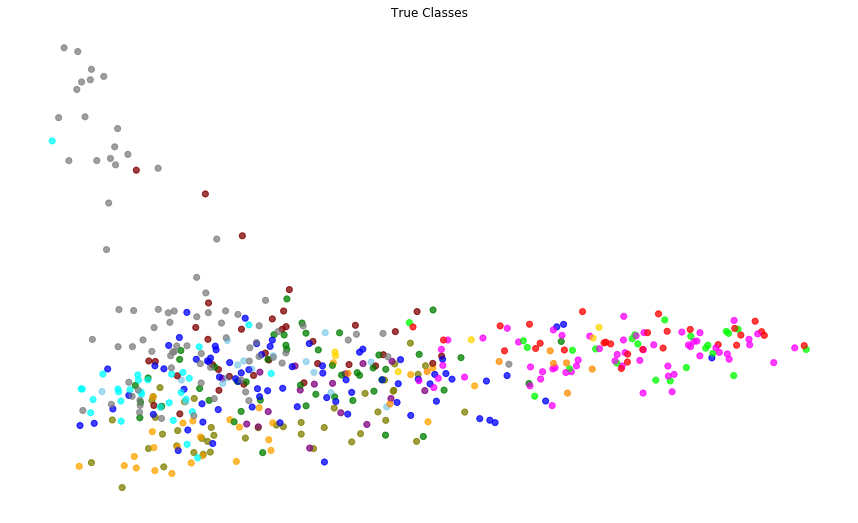

In [292]:
fig = plt.figure(figsize = (15,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

It is possible to see that there is some kind of clustering, specially in the left-top corner and the right size of the data. But as I was taught in a spatial analysis class, we, as social scientists, are trained to see clusters everywhere. Therefore, what might appear as a cluster may not actually be one.  

In [289]:
colors_p = [colordict[brown.categories()[l]] for l in km12.labels_]

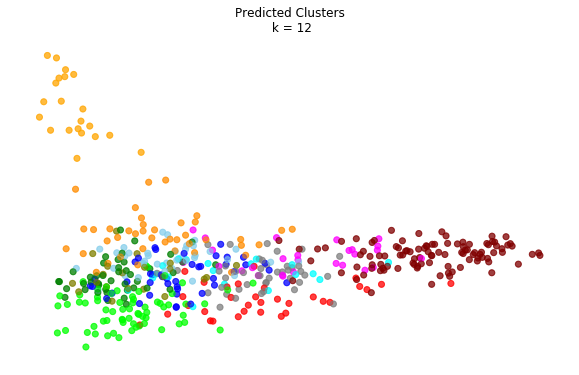

In [293]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 12')
plt.show()

This figure shows the actual clusters generated by the 12 clusters solution. The left-top corner cluster detected visually still appears. The maroon cluster to the right is also very clear. The same could be said about the lime cluster in the left-bottom corner. The other clusters seem to be more difficult to visualize.

Compared to the original classification, the 12 clusters solution fits the data better. The question is, though, if the clusters of that solution are actually the most efficient. I know run silhoutte analysis to test how different solutions fit the data.

In this case, the 12 clusters solution is actually the worse of all. This might tell us something about the original classification of the data. MAYBE IT IS NOT THE BEST CATEGORIZATION!!! The 11 clusters solution appears as the best one. It is interesting to see that 11 actually differs significantly from 15. 

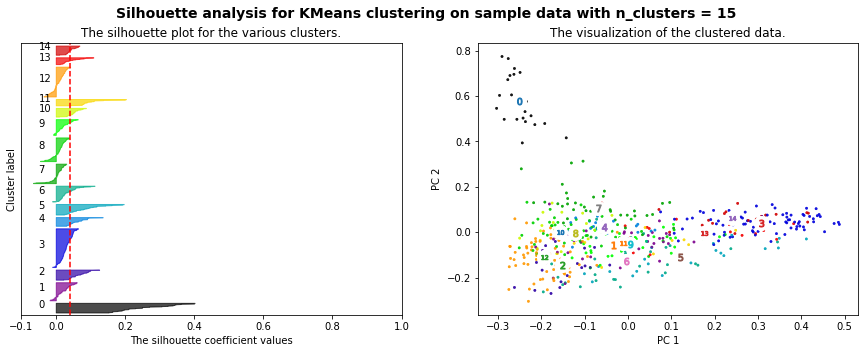

For n_clusters = 15, The average silhouette_score is : 0.040


In [242]:
X = BrownCatTFVects.toarray()
plotSilhouette(15, X)

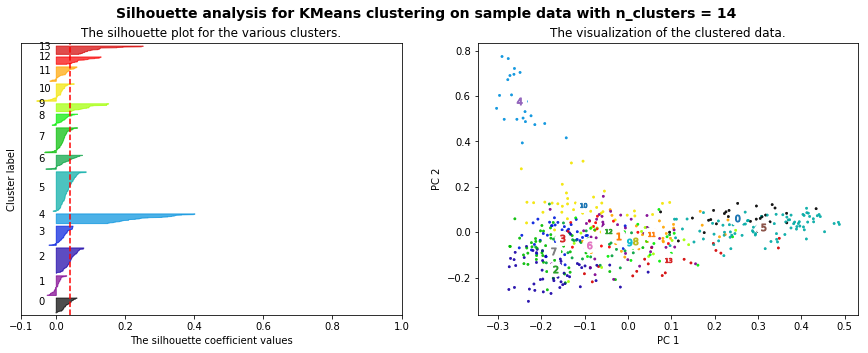

For n_clusters = 14, The average silhouette_score is : 0.042


In [243]:
X = BrownCatTFVects.toarray()
plotSilhouette(14, X)

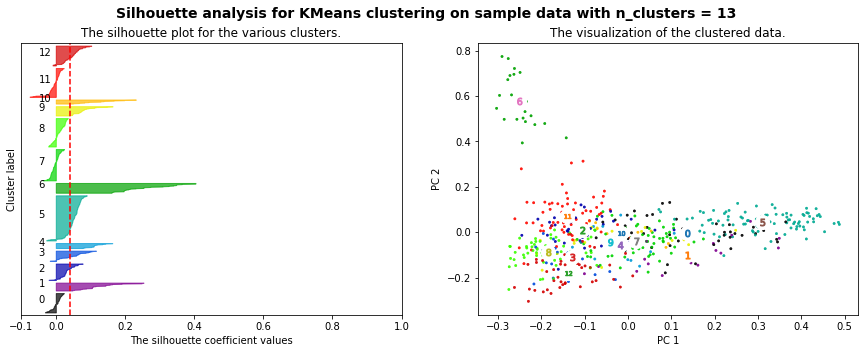

For n_clusters = 13, The average silhouette_score is : 0.041


In [244]:
X = BrownCatTFVects.toarray()
plotSilhouette(13, X)

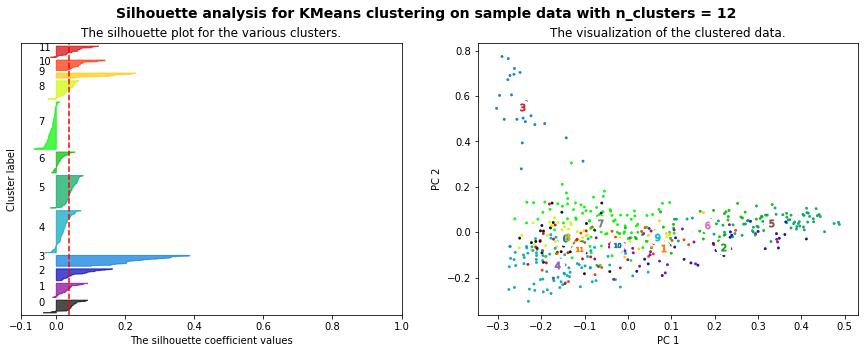

For n_clusters = 12, The average silhouette_score is : 0.038


In [245]:
X = BrownCatTFVects.toarray()
plotSilhouette(12, X)

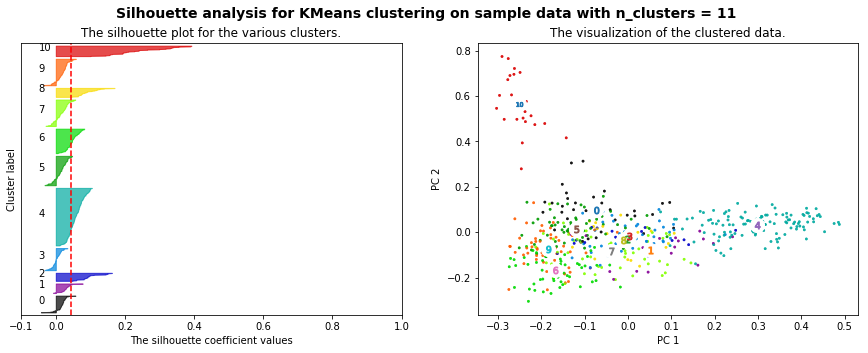

For n_clusters = 11, The average silhouette_score is : 0.044


In [246]:
X = BrownCatTFVects.toarray()
plotSilhouette(11, X)

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [140]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [141]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [142]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate

/Users/arielazar/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [143]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [144]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [145]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/Users/arielazar/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 93.        ,  95.        ,   0.        ,   2.        ],
       [ 98.        , 200.        ,   0.        ,   3.        ],
       [176.        , 201.        ,   0.        ,   4.        ],
       [  5.        , 202.        ,   0.37033177,   5.        ],
       [ 69.        , 154.        ,   0.40914841,   2.        ],
       [ 10.        ,  44.        ,   0.44134524,   2.        ],
       [ 49.        ,  62.        ,   0.45096656,   2.        ],
       [ 51.        , 204.        ,   0.4553535 ,   3.        ],
       [167.        , 206.        ,   0.4650683 ,   3.        ],
       [  2.        ,  46.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

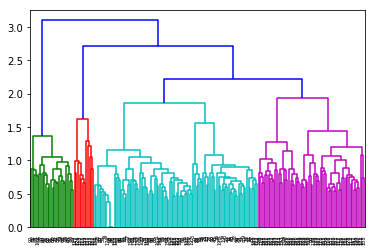

In [146]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

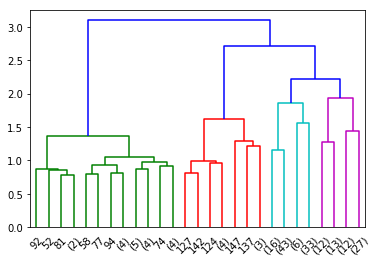

In [147]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [148]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1,
       1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3,
       4, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 4, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4,
       3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4, 3, 2, 2, 2, 4, 2, 4, 4, 3, 4,
       2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4, 4, 4, 4, 2, 4, 3, 3, 4, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4,
       3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [149]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

/Users/arielazar/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [150]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,category,source_file,text,kmeans_predictions,wald_predictions
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ...",0,4
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...,0,4
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...,0,4
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom",0,4
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...,0,4
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David,0,4
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,0,4
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not...",0,4
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...,0,3
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...,0,4


# Now let's do it with our new data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [151]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/Users/arielazar/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
/Users/arielazar/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

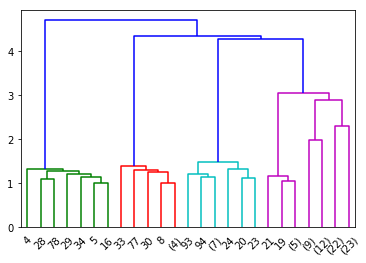

In [152]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [153]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

/Users/arielazar/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


As we only used one senator for this there isn't any point in looking at the metrics, but you should if possible

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

Lets first visualize the tree we will cut in order to create the different clusters.

Since this doesnt tell us much, I will just create different clusters solutions and compare them between them and to the ones created above.

In [295]:
BrownCatCoocMat = BrownCatTFVects * BrownCatTFVects.T
BrownCatCoocMat.setdiag(0)
BrownCatlinkage_matrix = scipy.cluster.hierarchy.ward(BrownCatCoocMat[:100, :100].toarray())

/Users/arielazar/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


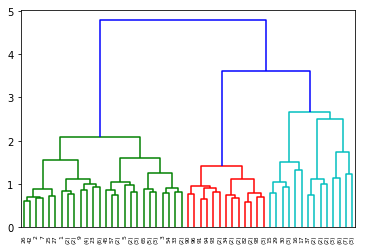

In [296]:
ax = scipy.cluster.hierarchy.dendrogram(BrownCatlinkage_matrix, p=5, truncate_mode='level')

In [301]:
BrownCatlinkage_matrix = scipy.cluster.hierarchy.ward(BrownCatCoocMat.toarray())

hierarchicalClusters_full_15 = scipy.cluster.hierarchy.fcluster(BrownCatlinkage_matrix, 15, 'maxclust')
hierarchicalClusters_full_14 = scipy.cluster.hierarchy.fcluster(BrownCatlinkage_matrix, 14, 'maxclust')
hierarchicalClusters_full_13 = scipy.cluster.hierarchy.fcluster(BrownCatlinkage_matrix, 13, 'maxclust')
hierarchicalClusters_full_12 = scipy.cluster.hierarchy.fcluster(BrownCatlinkage_matrix, 12, 'maxclust')
hierarchicalClusters_full_11 = scipy.cluster.hierarchy.fcluster(BrownCatlinkage_matrix, 11, 'maxclust')
hierarchicalClusters_full_10 = scipy.cluster.hierarchy.fcluster(BrownCatlinkage_matrix, 10, 'maxclust')


print("For the 15 clusters solution:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(BrownCatDF['category'], hierarchicalClusters_full_15)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(BrownCatDF['category'], hierarchicalClusters_full_15)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(BrownCatDF['category'], hierarchicalClusters_full_15)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(BrownCatDF['category'], hierarchicalClusters_full_15)))
print('\n')
print("For the 14 clusters solution:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(BrownCatDF['category'], hierarchicalClusters_full_14)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(BrownCatDF['category'], hierarchicalClusters_full_14)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(BrownCatDF['category'], hierarchicalClusters_full_14)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(BrownCatDF['category'], hierarchicalClusters_full_14)))
print('\n')
print("For the 13 clusters solution:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(BrownCatDF['category'], hierarchicalClusters_full_13)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(BrownCatDF['category'], hierarchicalClusters_full_13)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(BrownCatDF['category'], hierarchicalClusters_full_13)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(BrownCatDF['category'], hierarchicalClusters_full_13)))
print('\n')
print("For the 12 clusters solution:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(BrownCatDF['category'], hierarchicalClusters_full_12)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(BrownCatDF['category'], hierarchicalClusters_full_12)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(BrownCatDF['category'], hierarchicalClusters_full_12)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(BrownCatDF['category'], hierarchicalClusters_full_12)))
print('\n')
print("For the 11 clusters solution:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(BrownCatDF['category'], hierarchicalClusters_full_11)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(BrownCatDF['category'], hierarchicalClusters_full_11)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(BrownCatDF['category'], hierarchicalClusters_full_11)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(BrownCatDF['category'], hierarchicalClusters_full_11)))
print('\n')
print("For the 10 clusters solution:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(BrownCatDF['category'], hierarchicalClusters_full_10)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(BrownCatDF['category'], hierarchicalClusters_full_10)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(BrownCatDF['category'], hierarchicalClusters_full_10)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(BrownCatDF['category'], hierarchicalClusters_full_10)))

/Users/arielazar/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


For the 15 clusters solution:
Homogeneity: 0.363
Completeness: 0.350
V-measure: 0.356
Adjusted Rand Score: 0.153


For the 14 clusters solution:
Homogeneity: 0.354
Completeness: 0.354
V-measure: 0.354
Adjusted Rand Score: 0.150


For the 13 clusters solution:
Homogeneity: 0.346
Completeness: 0.357
V-measure: 0.352
Adjusted Rand Score: 0.151


For the 12 clusters solution:
Homogeneity: 0.338
Completeness: 0.364
V-measure: 0.351
Adjusted Rand Score: 0.153


For the 11 clusters solution:
Homogeneity: 0.330
Completeness: 0.366
V-measure: 0.347
Adjusted Rand Score: 0.153


For the 10 clusters solution:
Homogeneity: 0.324
Completeness: 0.381
V-measure: 0.350
Adjusted Rand Score: 0.160


Since I have a 'true' labeling of the data, i will use the V-measure to compare the solutions obtained to the original structure of the documents. According to this measure, the best clusters solution when using hierarchical modeling is the 15 clusters model. 

Unlike the k-means solution, which consisted of 12 clusters, this one is closer to the original classification when using 15 clusters. 

It must be noted, though, that when considereing the Adjusted Rand Score as a measure of fit of the clusters to the true classification, the 10-clusters solution appears as the best one. 

Either way, both kinds of solutions are telling us that apparently the original classification is not the best one for our documents.

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [154]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: nltk.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                            stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                            stemmer = lucem_illud.stemmer_basic))
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, contact, meli..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, washington, c..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, surpris, amer..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immedi, releas, washington, c, today, senat, ..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immedi, releas, veteran, day, america, stand,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, mr, chairman,..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immedi, releas, washington, c, senat, edward,..."


In [155]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [156]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [157]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [158]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [159]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [160]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(9, 0.9691229)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [161]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [162]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(0, 0.86820054), (3, 0.09432338)]",0.868201,0.000000,0.000000,0.094323,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
101,02Feb2007Kennedy10.txt,"[(1, 0.28390127), (3, 0.70931756)]",0.000000,0.283901,0.000000,0.709318,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
201,04May2006Kennedy8.txt,"[(4, 0.8734878), (5, 0.12389193)]",0.000000,0.000000,0.000000,0.000000,0.873488,0.123892,0.000000,0.0,0.000000,0.000000
301,06Jun2007Kennedy1.txt,"[(3, 0.7439187), (8, 0.25085208)]",0.000000,0.000000,0.000000,0.743919,0.000000,0.000000,0.000000,0.0,0.250852,0.000000
401,08Feb2005Kennedy0.txt,"[(1, 0.4920235), (9, 0.49857074)]",0.000000,0.492023,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.498571
501,09Nov2005Kennedy11.txt,"[(6, 0.9380035)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.938003,0.0,0.000000,0.000000
601,11Nov2005Kennedy6.txt,"[(0, 0.4056505), (1, 0.3587437), (8, 0.20428558)]",0.405650,0.358744,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.204286,0.000000
701,13Jun2006Kennedy1.txt,"[(0, 0.5142736), (2, 0.048248127), (5, 0.19236...",0.514274,0.000000,0.048248,0.000000,0.000000,0.192363,0.000000,0.0,0.143878,0.099065
801,15Dec2005Kennedy5.txt,"[(0, 0.113083616), (5, 0.8477727), (6, 0.03744...",0.113084,0.000000,0.000000,0.000000,0.000000,0.847773,0.037445,0.0,0.000000,0.000000
901,16May2007Kennedy5.txt,"[(5, 0.95709306)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.957093,0.000000,0.0,0.000000,0.000000


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [163]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.969123
1,0.868201,0.0,0.0,0.094323,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.991159
3,0.000000,0.0,0.0,0.991596,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.996807,0.000000,0.000000
5,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.432979,0.558743
6,0.000000,0.0,0.0,0.017649,0.900782,0.0,0.000000,0.000000,0.000000,0.067313
7,0.000000,0.0,0.0,0.962291,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
8,0.076479,0.0,0.0,0.000000,0.000000,0.0,0.154066,0.000000,0.000000,0.765450
9,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.965948


First we can visualize as a stacked bar chart:

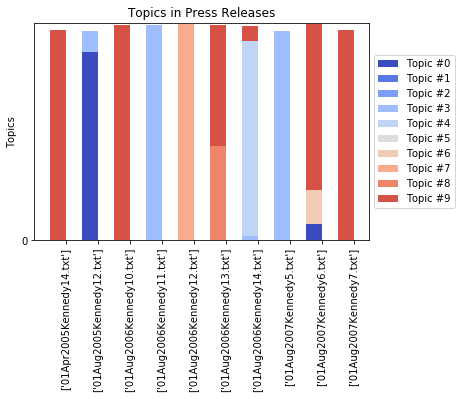

In [164]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

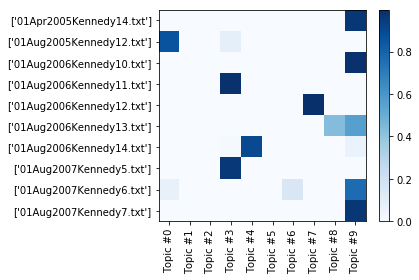

In [165]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [166]:
senlda.show_topic(1)

[('fund', 0.015226263),
 ('worker', 0.008027638),
 ('wagon', 0.007069385),
 ('author', 0.006567112),
 ('inform', 0.0063073244),
 ('train', 0.006131928),
 ('depart', 0.006057969),
 ('troop', 0.0060064197),
 ('commit', 0.005711488),
 ('import', 0.005653602)]

And if we want to make a dataFrame:

In [167]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,head,fund,fund,worker,document,fund,worker,worker,wage,loan
1,fund,worker,loan,fund,wagon,import,employ,pension,minimum,lender
2,depart,wagon,wagon,wage,fund,troop,govern,fund,worker,worker
3,worker,author,author,import,inform,wagon,amend,employ,wagon,wage
4,mental,inform,troop,minimum,iraqi,teacher,fund,wage,govern,govern
5,author,train,govern,fda,unit,commit,liheap,rate,amend,aid
6,teacher,depart,victim,depart,govern,loan,inform,wagon,unit,wagon
7,ill,troop,worker,unit,follow,medicaid,unit,govern,iraqi,fund
8,import,commit,assist,doe,robert,depart,parent,save,import,borrow
9,wagon,import,unit,wagon,stem,fail,ireland,import,fund,minimum


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

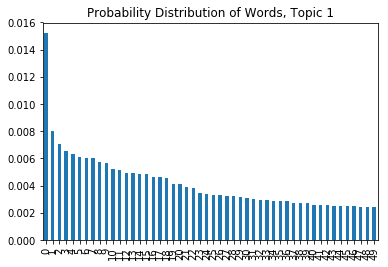

In [168]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [169]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

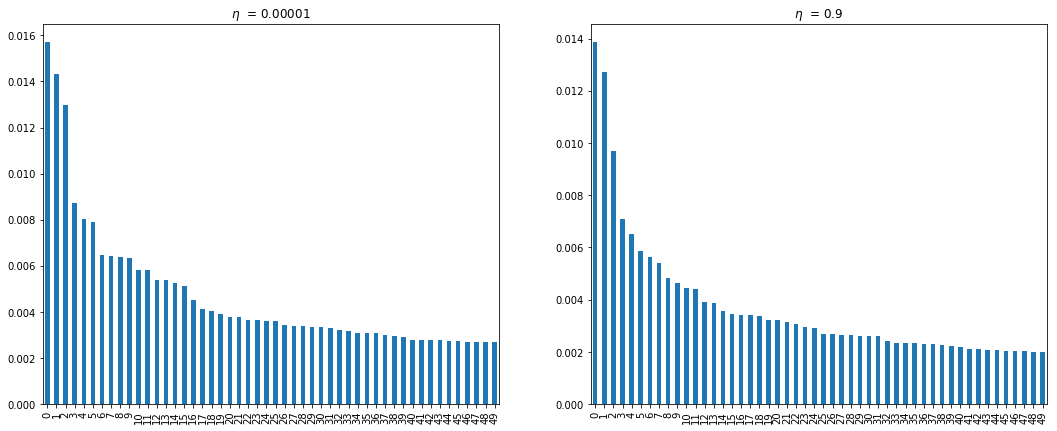

In [170]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

I will firt prepare the data for the topic modeling

In [251]:
#Apply our functions
BrownCatDF['tokenized_text'] = BrownCatDF['text'].apply(lambda x: nltk.word_tokenize(x))
BrownCatDF['normalized_tokens'] = BrownCatDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                            stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                            stemmer = lucem_illud.stemmer_basic))
BrownCatDF[::100]

,category,text,kmeans_predictions,tokenized_text,normalized_tokens
0,news,The Fulton County Grand Jury said Friday an in...,8,"[The, Fulton, County, Grand, Jury, said, Frida...","[fulton, counti, grand, juri, said, friday, in..."
100,religion,"If we look about the world today , we can see ...",4,"[If, we, look, about, the, world, today, ,, we...","[look, world, today, see, clear, two, especi, ..."
200,belles_lettres,"Nothing like Godot , he arrived before the hou...",10,"[Nothing, like, Godot, ,, he, arrived, before,...","[noth, like, godot, arriv, befor, hour, letter..."
300,learned,"The Poynting-Robertson effect ( Robertson , 19...",14,"[The, Poynting-Robertson, effect, (, Robertson...","[effect, robertson, wyatt, whippl, retard, orb..."
400,fiction,"`` But tell me , doctor , where do you plan to...",1,"[``, But, tell, me, ,, doctor, ,, where, do, y...","[tell, doctor, plan, conduct, hatch, alex, ask..."
500,news,The Fulton County Grand Jury said Friday an in...,8,"[The, Fulton, County, Grand, Jury, said, Frida...","[fulton, counti, grand, juri, said, friday, in..."
600,religion,"If we look about the world today , we can see ...",4,"[If, we, look, about, the, world, today, ,, we...","[look, world, today, see, clear, two, especi, ..."
700,belles_lettres,"Nothing like Godot , he arrived before the hou...",10,"[Nothing, like, Godot, ,, he, arrived, before,...","[noth, like, godot, arriv, befor, hour, letter..."
800,learned,"The Poynting-Robertson effect ( Robertson , 19...",14,"[The, Poynting-Robertson, effect, (, Robertson...","[effect, robertson, wyatt, whippl, retard, orb..."
900,fiction,"`` But tell me , doctor , where do you plan to...",1,"[``, But, tell, me, ,, doctor, ,, where, do, y...","[tell, doctor, plan, conduct, hatch, alex, ask..."


In [252]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

BrownCatDF['reduced_tokens'] = BrownCatDF['normalized_tokens'].apply(lambda x: dropMissing(x, BrownCatTFVectorizer.vocabulary_.keys()))

In [253]:
#BrownCatDF.to_csv('BrownCatDF_v2.csv', sep=',')
#BrownCatDF =  pandas.read_csv('BrownCatDF_v2.csv')
#BrownCatDF

In [254]:
dictionary = gensim.corpora.Dictionary(BrownCatDF['reduced_tokens'])

In [255]:
corpus = [dictionary.doc2bow(text) for text in BrownCatDF['reduced_tokens']]

In [302]:
gensim.corpora.MmCorpus.serialize('BrownCat.mm', corpus)
BrownCatmm = gensim.corpora.MmCorpus('BrownCat.mm')

Now I can proceed to do the topic modeling. I will first use 15 topics, because of the original structure of the data.

In [305]:
BrownCatlda = gensim.models.ldamodel.LdaModel(corpus=BrownCatmm, id2word=dictionary, num_topics=15, alpha='auto', eta='auto')

I will save which topics in the model predict documents load on and make this into a dataFrame for later analysis.

In [344]:
ldaDF = pandas.DataFrame({
        'category' : BrownCatDF['category'],
        'topics' : [BrownCatlda[dictionary.doc2bow(l)] for l in BrownCatDF['reduced_tokens']]
    })
ldaDF

,category,topics
0,news,"[(7, 0.15723498), (9, 0.21669962), (10, 0.3977..."
1,news,"[(2, 0.22450039), (6, 0.14625241), (7, 0.54090..."
2,news,"[(2, 0.07049112), (6, 0.24812058), (7, 0.04896..."
3,news,"[(2, 0.5004908), (12, 0.10897882), (14, 0.3838..."
4,news,"[(2, 0.023499), (3, 0.8784483), (10, 0.09455242)]"
5,news,"[(2, 0.508142), (5, 0.08285975), (10, 0.140921..."
6,news,"[(2, 0.2171323), (3, 0.013986063), (5, 0.20132..."
7,news,"[(2, 0.77210027), (5, 0.08783498), (7, 0.13567..."
8,news,"[(3, 0.7035225), (5, 0.053477492), (7, 0.03670..."
9,news,"[(2, 0.1754311), (6, 0.084739864), (9, 0.02597..."


In order to see how each document loads into each topic, we can visualize the loadings of each document into each topic. Let's take the first 20 documents. Since these are all news, we can visualize another set of documents. 

In [345]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(BrownCatlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(BrownCatlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDFV = ldaDF[:20][['topic_%d' %x for x in range(15)]]
ldaDFVisN = ldaDF[:20][['category']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.157235,0.000000,0.216700,0.397782,0.000000,0.000000,0.000000,0.213784
1,0.000000,0.000000,0.224500,0.000000,0.0,0.000000,0.146252,0.540902,0.000000,0.000000,0.084557,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.070491,0.000000,0.0,0.000000,0.248121,0.048964,0.000000,0.000000,0.595177,0.000000,0.000000,0.000000,0.034744
3,0.000000,0.000000,0.500491,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108979,0.000000,0.383879
4,0.000000,0.000000,0.023499,0.878448,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.094552,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.508142,0.000000,0.0,0.082860,0.000000,0.000000,0.000000,0.000000,0.140922,0.000000,0.056880,0.018200,0.190017
6,0.000000,0.000000,0.217132,0.013986,0.0,0.201321,0.000000,0.000000,0.000000,0.000000,0.056268,0.000000,0.149383,0.000000,0.358344
7,0.000000,0.000000,0.772100,0.000000,0.0,0.087835,0.000000,0.135674,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.703523,0.0,0.053477,0.000000,0.036705,0.000000,0.202122,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.175431,0.000000,0.0,0.000000,0.084740,0.000000,0.000000,0.025978,0.026283,0.000000,0.679763,0.000000,0.000000


In [365]:
ldaDFV_1 = ldaDF[88:105][['topic_%d' %x for x in range(15)]]
ldaDFVisN_1 = ldaDF[88:105][['category']]
ldaDFVis_1 = ldaDFV_1.as_matrix(columns=None)
ldaDFVisNames_1 = ldaDFVisN_1.as_matrix(columns=None)
ldaDFV_1

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
88,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.0,0.231542,0.108584,0.000000,0.655599,0.000000,0.000000,0.000000
89,0.000000,0.000000,0.051610,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.922409,0.021093,0.000000,0.000000
90,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.995722,0.000000,0.000000,0.000000
91,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.994246,0.000000
92,0.073614,0.000000,0.000000,0.000,0.0,0.000000,0.251767,0.0,0.000000,0.000000,0.035054,0.546404,0.055322,0.033476,0.000000
93,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.887169,0.108693,0.000000
94,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.047432,0.948640,0.000000
95,0.000000,0.000000,0.116747,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.878229,0.000000,0.000000,0.000000
96,0.000000,0.000000,0.068893,0.055,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.632804,0.240594,0.000000,0.000000
97,0.000000,0.000000,0.189470,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.476398,0.330060,0.000000,0.000000


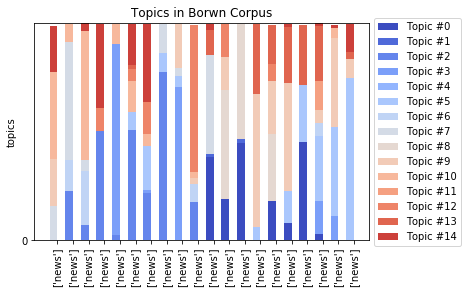

In [361]:
N = 20
ind = np.arange(N)
K = BrownCatlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('topics')

plt.title('Topics in Borwn Corpus')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

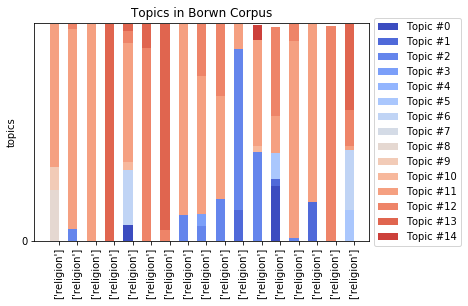

In [368]:
N = 17
ind = np.arange(N)
K = BrownCatlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis_1[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis_1[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis_1[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('topics')

plt.title('Topics in Borwn Corpus')
plt.xticks(ind+width/2, ldaDFVisNames_1, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

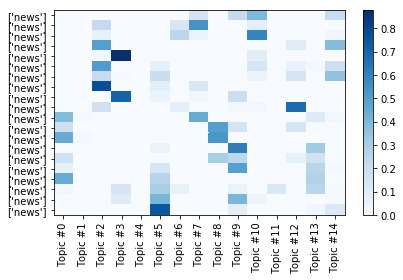

In [369]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

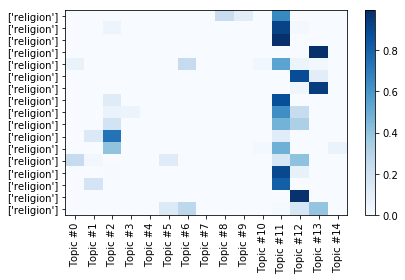

In [372]:
plt.pcolor(ldaDFVis_1, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis_1.shape[0])+0.5, ldaDFVisNames_1);
plt.xticks(np.arange(ldaDFVis_1.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

For the first 20 documents, which are all part of the 'news' category, it is hard to see to which topic the documents load higher. This might be to the very nature of 'news', since they might be about different topis. For the religion documents, though, it is easier to see that most documents load high in topic 11. As can be seen below, topic 11 includes the word 'church', 'person', 'present'. It makes sense for these words to be associated with documents labeled as religion documents. Nevertheless, the results are not so straightforawrd. This might be due to the fact that, as shown above, the documents seem to not be very well classified. 

In [373]:
BrownCatlda.show_topic(11)

[('year', 0.012019297),
 ('person', 0.008727963),
 ('state', 0.008516527),
 ('look', 0.00805511),
 ('number', 0.0077543985),
 ('church', 0.0076307855),
 ('mean', 0.007505936),
 ('white', 0.006571084),
 ('present', 0.0064912164),
 ('student', 0.006273314)]

As can be seen below, several topics include the same top words. As stated by the example shown, I can try to make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model.

As I show below, the probability distribution of words for topic 1---as an example---changes if we change this parameters.

A low $\alpha$ puts emphasis on having each document loading in only a few dominant topics, while a high $\alpha$ returns many more relatively dominant topics. Low $\eta$ values place more weight on having each topic composed of only a few dominant words.

As shown in the first to figures, when the $\alpha$ value is increased a few words load high on the first topic, while all other words have a low and similar loading. When the $\eta$ value is modified there are less diferences. A high $\eta$ increases the weight of the second most common word.

In [374]:
topicsDict = {}
for topicNum in range(BrownCatlda.num_topics):
    topicWords = [w for w, p in BrownCatlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,hand,look,state,year,state,year,state,state,year,af,year,cost,state,state,nation
1,look,turn,year,person,year,say,year,af,develop,thing,state,school,year,year,state
2,say,live,case,state,unit,state,school,year,program,number,american,year,school,look,general
3,want,hand,general,look,look,look,unit,point,state,look,look,look,form,af,year
4,year,fact,thing,number,think,word,american,line,general,mean,unit,hand,af,live,school
5,got,year,number,church,church,hand,feed,need,home,church,nation,thought,program,play,develop
6,nation,form,public,mean,need,brown,say,develop,room,ask,car,group,say,turn,look
7,car,thing,small,white,develop,nation,war,nation,clay,want,say,ask,person,thing,student
8,turn,feel,ask,present,eye,god,public,class,member,say,hand,children,water,section,case
9,went,follow,result,student,hand,set,look,program,need,state,public,think,hand,thought,open


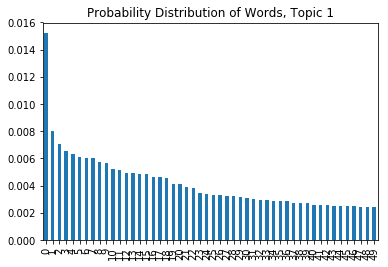

In [321]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

In [375]:
BrownCatlda1 = gensim.models.ldamodel.LdaModel(corpus=BrownCatmm, id2word=dictionary, num_topics=15, eta = 0.5, alpha=0.9)
BrownCatlda2 = gensim.models.ldamodel.LdaModel(corpus=BrownCatmm, id2word=dictionary, num_topics=15, eta = 0.5, alpha=0.00001)

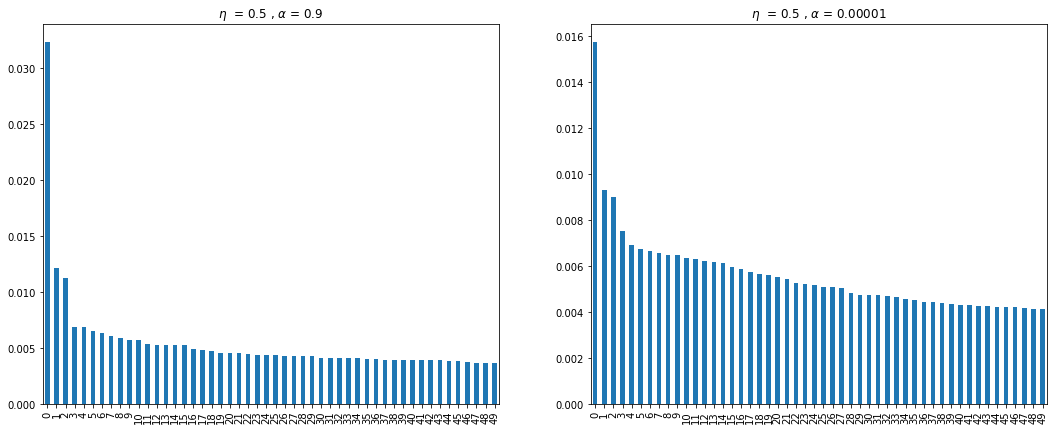

In [376]:
topic11_df = pandas.DataFrame(BrownCatlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(BrownCatlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.5 , 'r'$\alpha$ = 0.9')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.5 , 'r'$\alpha$ = 0.00001')
plt.show()

In [377]:
BrownCatlda3 = gensim.models.ldamodel.LdaModel(corpus=BrownCatmm, id2word=dictionary, num_topics=15, eta = 0.9, alpha=0.5)
BrownCatlda4 = gensim.models.ldamodel.LdaModel(corpus=BrownCatmm, id2word=dictionary, num_topics=15, eta = 0.00001, alpha=0.5)

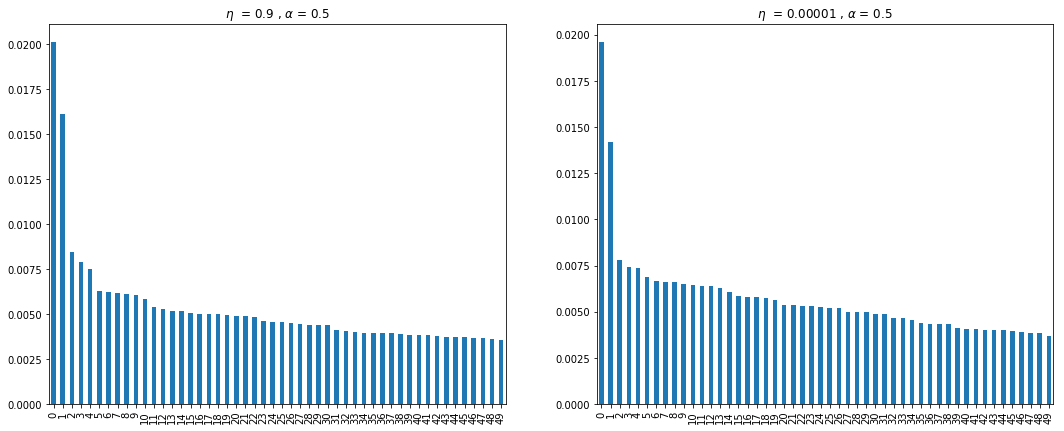

In [378]:
topic31_df = pandas.DataFrame(BrownCatlda3.show_topic(1, topn=50))
topic41_df = pandas.DataFrame(BrownCatlda4.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic31_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.9 , 'r'$\alpha$ = 0.5')
topic41_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.00001 , 'r'$\alpha$ = 0.5')
plt.show()